In [1]:
import datasets

imgnet = datasets.load_dataset('frgfm/imagenette', 'full_size', split='validation', ignore_verifications=False)
imgnet

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/datasets/load.py:2555: FutureWarning: 'ignore_verifications' was deprecated in favor of 'verification_mode' in version 2.9.1 and will be removed in 3.0.0.
You can remove this warning by passing 'verification_mode=all_checks' instead.
  warnings.warn(


Dataset({
    features: ['image', 'label'],
    num_rows: 3925
})

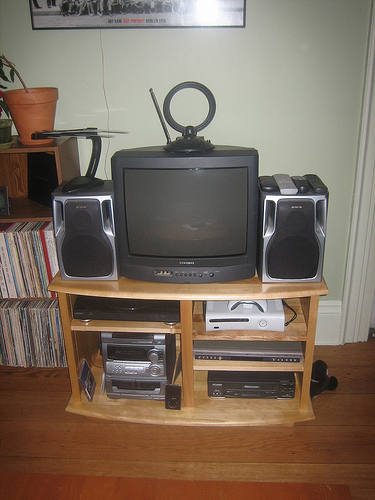

In [2]:
imgnet[5]['image']

In [3]:
import numpy as np
img_samples = [np.array(row['image']) for row in imgnet]
img_samples[0].shape

(487, 500, 3)

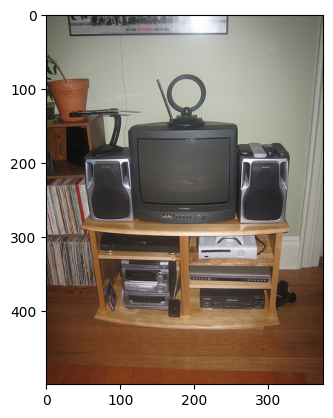

In [4]:
import matplotlib.pyplot as plt
plt.imshow(img_samples[5]);

In [5]:
import cv2

bwimgs = []
for img in img_samples:
    if len(img.shape) == 3:
        bwimgs.append(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY))
    else:
        bwimgs.append(img)

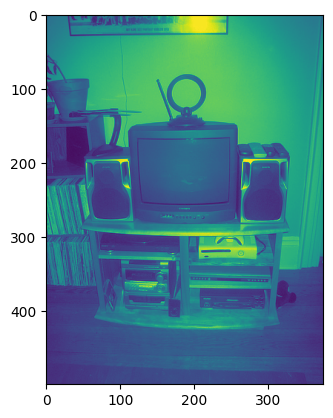

In [6]:
plt.imshow(bwimgs[5]);

In [7]:
import cv2
from tqdm import tqdm

extractor = cv2.SIFT_create()
keypoints = []
descriptors = []
for img in tqdm(bwimgs):
    img_keypoints, img_descriptors = extractor.detectAndCompute(img, None)
    keypoints.append(img_keypoints)
    descriptors.append(img_descriptors)

100%|██████████| 3925/3925 [04:11<00:00, 15.60it/s]


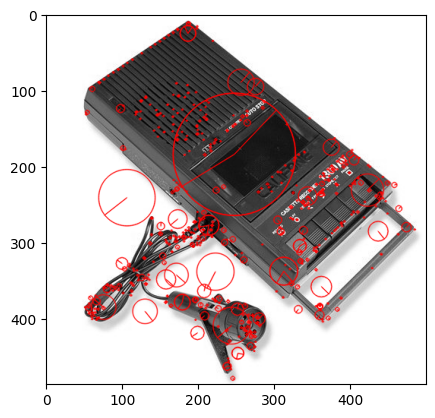

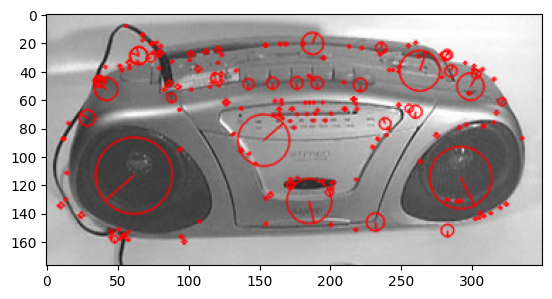

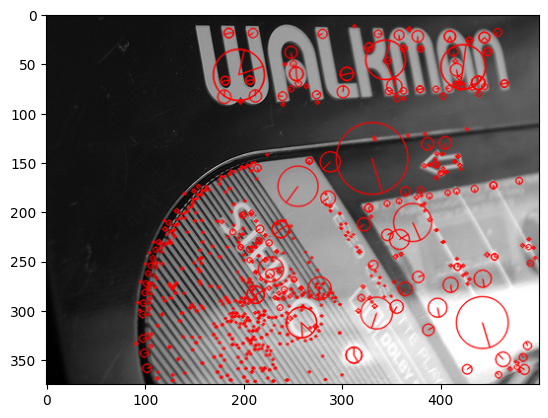

In [8]:
out_imgs = []
for i in range(3):
    out_imgs.append(cv2.drawKeypoints(bwimgs[i], keypoints[i], 0, (255, 0, 0), 
                                     flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS))
    plt.imshow(out_imgs[i], cmap='gray')
    plt.show();

In [9]:
np.random.seed(0)
sample_idx = np.random.randint(0, len(imgnet)+1, 1000).tolist()
descriptors_sample = []
for n in sample_idx:
    descriptors_sample.append(np.array(descriptors[n]))

In [10]:
all_descriptors = []
for img_desc in descriptors_sample:
    for desc in img_desc:
        all_descriptors.append(desc)
all_descriptors = np.stack(all_descriptors)

In [11]:
from scipy.cluster.vq import kmeans
k = 200
iters = 1
codebook, variance = kmeans(all_descriptors, k, iters)

In [12]:
from scipy.cluster.vq import vq
visual_words = []
for img_desc in descriptors:
    img_visual_words, distance = vq(img_desc, codebook)
    visual_words.append(img_visual_words)

In [13]:
visual_words[0][:5], len(visual_words[0])

(array([178, 115, 178,   0, 188], dtype=int32), 539)

In [14]:
frq_vecs = []
for img_vis_words in visual_words:
    img_frq_vec = np.zeros(k)
    for word in img_vis_words:
        img_frq_vec[word] += 1
    frq_vecs.append(img_frq_vec)
frq_vecs = np.stack(frq_vecs)
frq_vecs.shape

(3925, 200)

In [16]:
N = 3925
df = np.sum(frq_vecs > 0, axis=0)

In [17]:
idf = np.log(N/df)
idf.shape, idf[:5]

((200,), array([0.13422317, 0.55866083, 0.25058676, 0.12263555, 2.47300325]))

In [18]:
tfidf = frq_vecs * idf
tfidf.shape, tfidf[0][:5]

((3925, 200),
 array([0.93956219, 0.55866083, 0.75176028, 0.73581333, 4.94600651]))

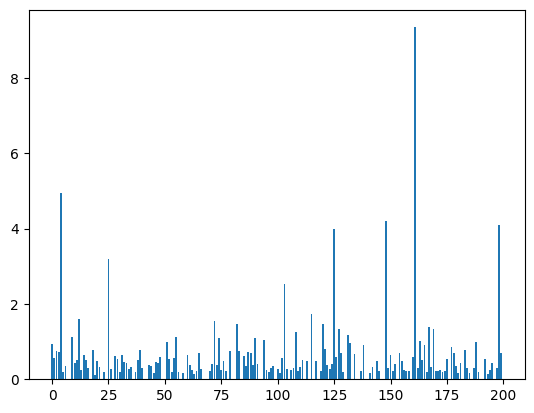

In [19]:
plt.bar(range(k), tfidf[0])
plt.show();

370: 1.0


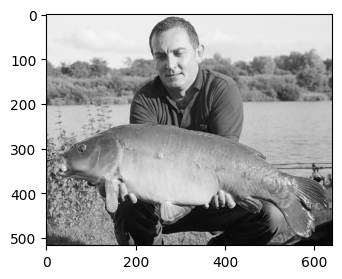

733: 0.9034


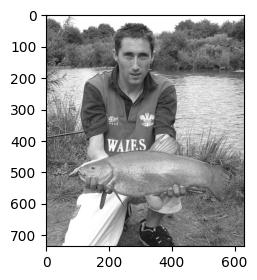

669: 0.8911


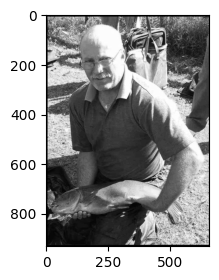

948: 0.8905


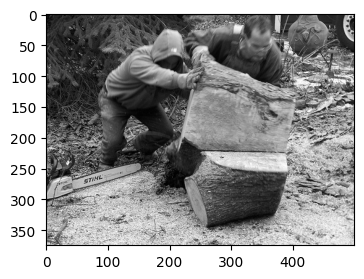

1200: 0.8766


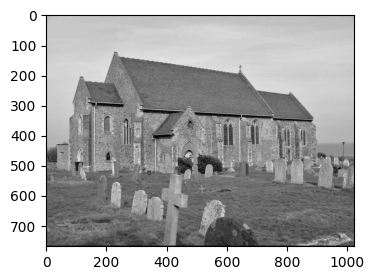

In [30]:
from numpy.linalg import norm
top_k = 5
i = 370
a = tfidf[i]
b = tfidf
cos_sim = np.dot(a, b.T)/(norm(a) * norm(b, axis=1))
idx = np.argsort(-cos_sim)[:top_k]
for next_i in idx:
    plt.figure(figsize=(10, 3))
    print(f"{next_i}: {round(cos_sim[next_i], 4)}")
    plt.imshow(bwimgs[next_i], cmap='gray')
    plt.show();